# 2/5/20

**Задача**: в связи с тем, что мне удаётся посчитать радиационную поправку к сечению, используя только "мягкие" фотоны, возникает вопрос, почему рад.поправка расходится, когда я учитываю все фотоны?
Я предположил, что проблема в устаревших данных в MC, так как рад.поправка в MC рассчитывается по сечениям, заложенным в него, поэтому я изменил сечения для MC на свои собственные и сделал новое моделирование.

Теперь я буду сравнивать старое и новое MC и посмотрю, что получилось

In [242]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(rc={'figure.figsize':(20,13)}, font_scale=1.5)
sns.set_style("white")

%matplotlib inline

# 1. Получить эффективность регистрации от энергии для старого и нового MC

In [215]:
def piDeDx(P):
    return 5.58030e+9 / np.power(P + 40., 3) + 2.21228e+3 - 3.77103e-1 * P;

def pCut(E):
    return 2 * (0.0869 * E - 36.53)

def pIdeal(E):
    return np.sqrt(E**2 - 497.6**2)

def open_file(filepath):
    df = uproot.open(filepath)['tr_ph']
    df_tracks = df.pandas.df(branches=['tptot', 'nt', 'tdedx', 'tz', 'tth', 'tphi', 'tnhit', \
                                          'tchi2r', 'tchi2z', 'trho', 'emeas'])
    df_ks = df.pandas.df(branches=['nks', 'ksptot', 'ksth', 'ksphi', 'ksminv', 'emeas', 'ksalign', 'ksvind'])
    df_sim = df.pandas.df(branches=['emeas', 'simtype', 'nsim', 'simorig', 'simmom'])
    
    return df_tracks, df_ks, df_sim

def two_good_tracks_events(df_tracks):
    #Cuts
    pmin_cut = 40
    z_cut = 13
    theta_cut = 0.6
    theta2_cut = np.pi - theta_cut
    hit_cut = 6
    chi2r_cut = 30
    chi2z_cut = 25
    rho_cut = 0.1
    
    df_tracks = df_tracks.query('nt>=2&\
                tptot>@pmin_cut&\
                tptot<1.1*emeas&\
                abs(tz)<@z_cut&\
                tchi2r<@chi2r_cut&\
                tchi2z<@chi2z_cut&\
                tth>@theta_cut&tth<@theta2_cut&\
                tnhit>@hit_cut&\
                abs(trho)>@rho_cut').drop(['nt', 'tz', 'tchi2r', 'tchi2z', 'tnhit', 'trho'], axis=1)
    df_tracks = df_tracks[ np.abs( piDeDx(df_tracks.tdedx) ) < 2000 ]
    
    df_two_good_tracks = df_tracks.groupby('entry').agg({'tptot':'count'}).query('tptot==2')
    df_tracks = df_tracks.loc[ df_two_good_tracks.index ]
       
    return df_tracks

def good_ks(df_ks):
    if 'ksvind[2]' in df_ks:
        ksvind_drops = [f'ksvind[{i}]' for i in range(2,20)]
        df_ks.drop(ksvind_drops, axis=1, inplace=True)
    
    align_cut = 0.8 
    
    df_ks = df_ks.assign(difmass = np.abs(df_ks['ksminv'] - 497.6) )
    min_difmasses = df_ks.groupby('entry').agg({'difmass':np.min})
    df_ks = pd.merge(min_difmasses, df_ks, on=['difmass', 'entry']).drop(['difmass'], axis=1)
    
    df_ks = df_ks.query('ksalign>@align_cut')
    df_ks = df_ks[ np.abs( df_ks['ksptot'] - pIdeal(df_ks['emeas']) ) < pCut(df_ks['emeas']) ]
    
    df_ks = df_ks.rename({'ksvind[0]':'ksvind_0', 'ksvind[1]':'ksvind_1'}, axis=1)
    
    return df_ks.drop(['nks'], axis=1)
    
def merge(df_tracks, df_ks):
    good_tracks_indexes = pd.DataFrame( df_tracks.to_records() ).set_index('entry').\
                                    groupby('entry').agg(ksvind_0 = ('subentry', 'min'),\
                                                         ksvind_1 = ('subentry','max') )
    result = pd.merge(good_tracks_indexes, df_ks, on=['entry', 'ksvind_0', 'ksvind_1'])
    return result.drop(['ksvind_0', 'ksvind_1'], axis=1)

def soft_photon_events(df_sim0):
    df_sim = df_sim0.query('simtype==310').copy()
    if df_sim.simmom.mean() < 1:
        df_sim.simmom = df_sim.simmom*1e3
    df_sim = df_sim[ np.abs( df_sim['simmom'] - pIdeal(df_sim['emeas']) ) < pCut(df_sim['emeas']) ]
    return df_sim

##MAIN PART
def transform(file):
    df_tracks, df_ks, df_sim = open_file(file)
    df_tracks = two_good_tracks_events(df_tracks)
    df_ks = good_ks(df_ks)
    result_table = merge(df_tracks, df_ks)
    photon_table = soft_photon_events(df_sim)
    return result_table, photon_table

#### Заметки
1. В новом моделировании нет пионов из распада $K_S$ и импульсы в ГэВ

### Получить результаты для старого моделирования

In [276]:
eff_old = {}
eff_soft_old = {}

for file in glob.glob('/store17/lukinp/Analysis/klks_high/sim/tr_ph/*.root'):
    table, photons = transform(file)
    eff_soft_old[ table['emeas'].values[0] ] = [ table.shape[0]/photons.shape[0], np.sqrt(table.shape[0])/photons.shape[0]]
    eff_old[ table['emeas'].values[0] ] = [ table.shape[0]/2e4, np.sqrt(table.shape[0])/2e4]
    print(table['emeas'].values[0], end='\t')

775.0	787.5	975.0	850.0	687.5	900.0	1000.0	787.5	887.5	562.5	650.0	935.0	625.0	587.5	987.5	945.0	925.0	650.0	862.5	912.5	987.5	750.0	687.5	950.0	762.5	575.0	725.0	550.0	900.0	612.5	600.0	662.5	945.0	687.5	825.0	700.0	875.0	887.5	962.5	737.5	812.5	987.5	975.0	812.5	800.0	837.5	700.0	712.5	887.5	662.5	600.0	950.0	800.0	725.0	1000.0	962.5	975.0	837.5	575.0	935.0	1000.0	737.5	550.0	862.5	637.5	837.5	637.5	637.5	775.0	762.5	612.5	925.0	862.5	850.0	675.0	762.5	712.5	562.5	750.0	935.0	675.0	625.0	925.0	825.0	962.5	725.0	875.0	912.5	587.5	

In [277]:
eff_new = {}
eff_soft_new = {}

for file in glob.glob('/store17/petrov/data/kskl_sim_custom/tr_ph/*.root'):
    table, photons = transform(file)
    eff_soft_new[ table['emeas'].values[0] ] = [ table.shape[0]/photons.shape[0], np.sqrt(table.shape[0])/photons.shape[0]]
    eff_new[ table['emeas'].values[0] ] = [ table.shape[0]/2e4, np.sqrt(table.shape[0])/2e4]
    print(table['emeas'].values[0], end='\t')

/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


525.0	537.5	562.5	575.0	587.5	550.0	612.5	625.0	637.5	600.0	662.5	675.0	687.5	650.0	712.5	725.0	737.5	700.0	762.5	775.0	787.5	750.0	812.5	825.0	837.5	800.0	862.5	875.0	887.5	850.0	912.5	925.0	935.0	945.0	900.0	962.5	975.0	987.5	950.0	1000.0	

# Сравнение эффективностей регистрации

In [278]:
def plot_reg_eff(eff_old, eff_new, title):
    efficiency_old = pd.DataFrame.from_dict(eff_old, orient='index').sort_index()
    efficiency_new = pd.DataFrame.from_dict(eff_new, orient='index').sort_index()
    
    plt.figure(figsize=(13,7))
    plt.errorbar(efficiency_old.index, efficiency_old[0], yerr=efficiency_old[1], label='Old', fmt='o', ms=7)
    plt.errorbar(efficiency_new.index, efficiency_new[0], yerr=efficiency_new[1], label='New', fmt='o', ms=7)
    plt.legend(frameon=True)
    plt.title(title)
    plt.xlabel('Energy, MeV')
    plt.ylabel('Registration efficiency')
    plt.grid(linestyle=':');    
    return

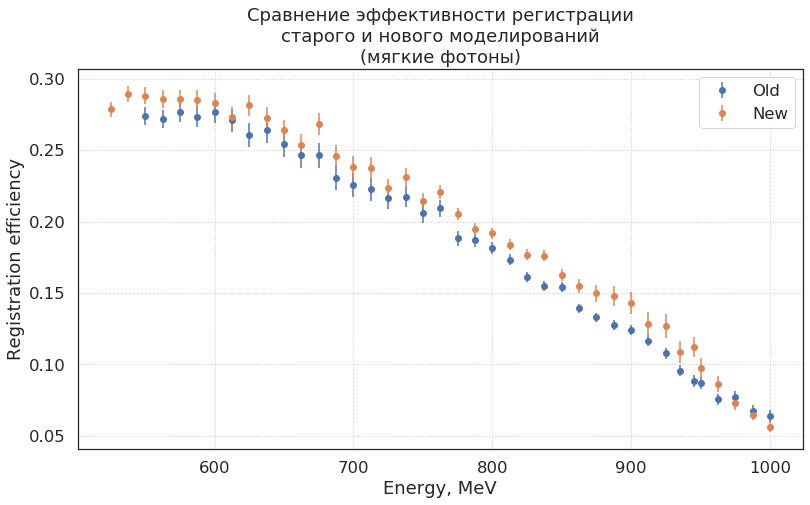

In [279]:
plot_reg_eff(eff_soft_old, eff_soft_new, \
    'Сравнение эффективности регистрации\nстарого и нового моделирований\n(мягкие фотоны)')

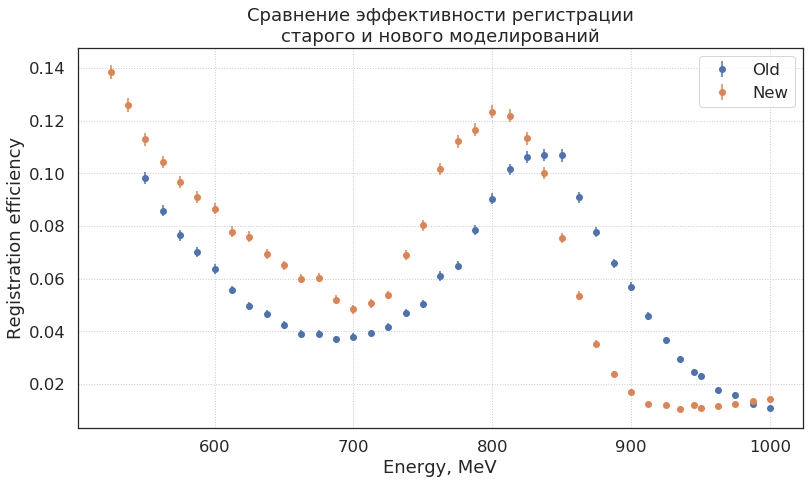

In [280]:
plot_reg_eff(eff_old, eff_new, \
    'Сравнение эффективности регистрации\nстарого и нового моделирований')

Видно, что эффективности регистрации с учётом рад.фотонов существенно различаются для старого и нового моделирования.
Однако, учёт только мягких фотонов практически не влияет на окончательный результат

Следующая задача посмотреть, как изменятся сечения с новыми эффективностями регистрации